In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file = uproot.open(f"{loc.DATA}/FCCDelphesOutput.root")
tree = file['events']

Access the generated truth-level particles from `genParticles`:

In [2]:
g_container = "genParticles.core"
g = tree.arrays(filter_name=f"{g_container}*",how="zip")
g[g_container,'p4.p'] = kinematics.calc_p(g,g_container)

Access the reco hadrons from `efcharged`:

In [3]:
h_container = "efcharged.core"
h = tree.arrays(filter_name=f"{h_container}*",how="zip")
h[h_container,'p4.p'] = kinematics.calc_p(h,h_container)

Access the particle to MC particle info for the charged hadrons:

In [4]:
h_toMC_container = "efchargedToMC#1"
h_toMC = tree.arrays(filter_name=f"{h_toMC_container}*",how="zip")

Associate the generated particle with the reco particle according to the index of `h_toMC`. Store the generated particle in `h["gen"]`:

In [5]:
h["gen"] = g[g_container][h_toMC[h_toMC_container,'index']]

Calculate difference in momentum between the reco and associated true particle:

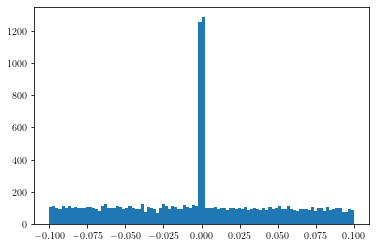

In [6]:
h["delta_p"] = h[h_container,'p4.p'] - h['gen','p4.p']
h["delta_p_per"] = h["delta_p"] / h['gen','p4.p']

plt.hist(ak.flatten(h["delta_p_per"]),bins=100,range=(-0.1,0.1))
plt.show()